# Exploratory Data Analysis - Combined Dataset
## California Wildfire Risk Data (2000-2024)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from pprint import pprint

df = pl.read_parquet('data/ca_combined_data.parquet')
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.estimated_size(unit='gb'):,.2f} GB")
del df

df = pl.scan_parquet('data/ca_combined_data.parquet')

Dataset shape: (423677400, 14)
Memory usage: 39.90 GB


## 1. Dataset Overview

In [ ]:
pprint(df.collect_schema())

display(df.head().collect())

In [ ]:
# df.describe()

## 2. Null Value Analysis

In [ ]:
# Calculate null counts calculation using Polars (for LazyFrame)
null_counts = df.select(pl.all().null_count()).collect()
total_rows = df.select(pl.len()).collect().item()

# Create the summary DataFrame
null_stats = pd.DataFrame({
    'Null_Count': null_counts.row(0),
    'Dtype': [str(t) for t in df.collect_schema().dtypes()]
}, index=null_counts.columns)

# Calculate percentage and non-nulls
null_stats['Null_Percentage'] = (null_stats['Null_Count'] / total_rows * 100).round(2)
null_stats['Non_Null_Count'] = total_rows - null_stats['Null_Count']

# Reorder and sort
null_stats = null_stats[['Null_Count', 'Null_Percentage', 'Non_Null_Count', 'Dtype']]
null_stats = null_stats.sort_values('Null_Percentage', ascending=False)

display(null_stats)
del null_counts, total_rows

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
null_pct = null_stats['Null_Percentage'].sort_values(ascending=True)
colors = ['#2ecc71' if x == 0 else '#e74c3c' if x > 20 else '#f39c12' for x in null_pct]

null_pct.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Null Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Variable', fontsize=12, fontweight='bold')
ax.set_title('Null Value Percentage by Variable', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(null_pct):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

del null_stats, null_pct

### Null Value Correlation

In [ ]:
null_indicators = df.select(pl.all().is_null().cast(pl.Int8)).collect()
null_corr_pl = null_indicators.corr()

null_corr = null_corr_pl.to_pandas()
null_corr.index = null_corr.columns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(null_corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Null Value Correlation Matrix\n(1.0 = variables are null together)', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

del null_indicators, null_corr_pl, null_corr

### Temporal Missingness Analysis

In [ ]:
# Null counts over time using Polars
temporal_nulls = df.group_by(['year', 'month']).agg([
    (pl.col('ppt').null_count() / pl.len() * 100).alias('ppt_null_pct'),
    (pl.col('ndvi').null_count() / pl.len() * 100).alias('ndvi_null_pct'),
    (pl.col('landcover').null_count() / pl.len() * 100).alias('landcover_null_pct'),
    (pl.col('elevation').null_count() / pl.len() * 100).alias('elevation_null_pct'),
    pl.len().alias('total_records')
]).collect().to_pandas()

temporal_nulls = temporal_nulls.sort_values(['year', 'month'])

temporal_nulls['date'] = pd.to_datetime(
    temporal_nulls['year'].astype(str) + '-' + temporal_nulls['month'].astype(str) + '-01'
)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Null percentages over time
axes[0].plot(temporal_nulls['date'], temporal_nulls['ppt_null_pct'], 
            marker='o', label='PRISM (ppt)', linewidth=2)
axes[0].plot(temporal_nulls['date'], temporal_nulls['ndvi_null_pct'], 
            marker='s', label='NDVI', linewidth=2)
axes[0].plot(temporal_nulls['date'], temporal_nulls['landcover_null_pct'], 
            marker='^', label='Landcover', linewidth=2)
axes[0].plot(temporal_nulls['date'], temporal_nulls['elevation_null_pct'], 
            marker='^', label='elevation', linewidth=2)
axes[0].set_ylabel('Null Percentage (%)', fontweight='bold', fontsize=11)
axes[0].set_title('Null Percentage Over Time', fontweight='bold', fontsize=13, pad=15)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 100)

# Total records over time
axes[1].bar(temporal_nulls['date'], temporal_nulls['total_records'], 
           width=20, alpha=0.7, color='steelblue')
axes[1].set_xlabel('Date', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Total Records', fontweight='bold', fontsize=11)
axes[1].set_title('Total Records Over Time', fontweight='bold', fontsize=13, pad=15)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

del temporal_nulls

### Missingness in NDVI

In [ ]:
ndvi_null_stats = df.group_by(['year', 'month']).agg([
    (pl.col('ndvi').null_count() / pl.len() * 100).alias('ndvi_null_%'),
    pl.len().alias('total_records')
]).collect().to_pandas()

ndvi_null_stats = ndvi_null_stats.sort_values(['year', 'month'])

ndvi_null_stats['date'] = pd.to_datetime(
    ndvi_null_stats['year'].astype(str) + '-' + ndvi_null_stats['month'].astype(str) + '-01'
)

ndvi_null_stats.plot(x='date', y='ndvi_null_%', kind='line', title='NDVI Null Percentage Over Time', linewidth=3, figsize=(12, 8))
plt.show()

del ndvi_null_stats

### Insights:

The missingness in NDVI data is 100% in January 2000 and drops to a more stable percentage from February 2000 onwards. This is because the MODIS satellite was launched in December 1999 and began data collection in February 2000.

Since the data is missing by design, we can drop the data for January 2000.

In [2]:
df = df.filter(~((pl.col('year') == 2000) & (pl.col('month') == 1)))

In [ ]:
# Display unique counts of (month, year) grouped by year
df.select(['month', 'year']).group_by('year').n_unique().collect().sort('year')

year,month
i32,u32
2000,11
2001,12
2002,12
2003,12
2004,12
…,…
2020,12
2021,12
2022,12


### Spatial Missingness Analysis

In [3]:
cols_to_select = ['year', 'month', 'lat', 'lon', 'ppt', 'tdmean', 'tmax', 'vpdmax', 'ndvi', 'landcover', 'elevation', 'slope', 'aspect']

null_df = df.select(cols_to_select).with_columns([
    pl.col('ppt').is_null().alias('ppt_null'),
    pl.col('tdmean').is_null().alias('tdmean_null'),
    pl.col('tmax').is_null().alias('tmax_null'),
    pl.col('vpdmax').is_null().alias('vpdmax_null'),
    pl.col('ndvi').is_null().alias('ndvi_null'),
    pl.col('landcover').is_null().alias('landcover_null'),
    pl.col('elevation').is_null().alias('elevation_null'),
    pl.col('slope').is_null().alias('slope_null'),
    pl.col('aspect').is_null().alias('aspect_null')
])

null_df.head().collect()

year,month,lat,lon,ppt,tdmean,tmax,vpdmax,ndvi,landcover,elevation,slope,aspect,ppt_null,tdmean_null,tmax_null,vpdmax_null,ndvi_null,landcover_null,elevation_null,slope_null,aspect_null
i32,i32,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool
2000,2,42.00833,-124.475,null,null,null,null,null,null,null,null,null,true,true,true,true,true,true,true,true,true
2000,2,42.00833,-124.46667,null,null,null,null,null,null,null,null,null,true,true,true,true,true,true,true,true,true
2000,2,42.00833,-124.45833,null,null,null,null,null,null,null,null,null,true,true,true,true,true,true,true,true,true
2000,2,42.00833,-124.45,null,null,null,null,null,null,null,null,null,true,true,true,true,true,true,true,true,true
2000,2,42.00833,-124.44167,null,null,null,null,null,null,null,null,null,true,true,true,true,true,true,true,true,true


In [ ]:
# Calculate spatial null percentages using Polars
cols_to_agg = ['ppt_null', 'tdmean_null', 'tmax_null', 'vpdmax_null', 'ndvi_null', 'landcover_null', 'elevation_null', 'slope_null', 'aspect_null']

spatial_nulls = null_df.group_by(['lat', 'lon']).agg(
    [pl.col(c).mean().alias(c) for c in cols_to_agg]
)

# Scale percentages (0-1 to 0-100) using Polars `with_columns`
spatial_nulls = spatial_nulls.with_columns(
    [(pl.col(c) * 100).alias(c) for c in cols_to_agg]
)

def plot_null_map(target_col):
    # Collect data for plotting
    print("Collecting data")
    plot_data = spatial_nulls.select(['lat', 'lon', target_col]).collect()
    print("Collected data")
    
    plt.figure(figsize=(12, 10))
    
    # Scatter plot
    print("Plotting")
    sc = plt.scatter(
        plot_data['lon'], 
        plot_data['lat'], 
        c=plot_data[target_col], 
        cmap='RdYlGn_r',
        s=10, 
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(sc, label=f"{target_col} (%)")
    
    plt.title(f"Spatial Distribution of Null Values (%) - {target_col}", fontsize=14, fontweight='bold')
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Set aspect ratio to 'equal' to preserve map shape
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

Collected data
Plotting


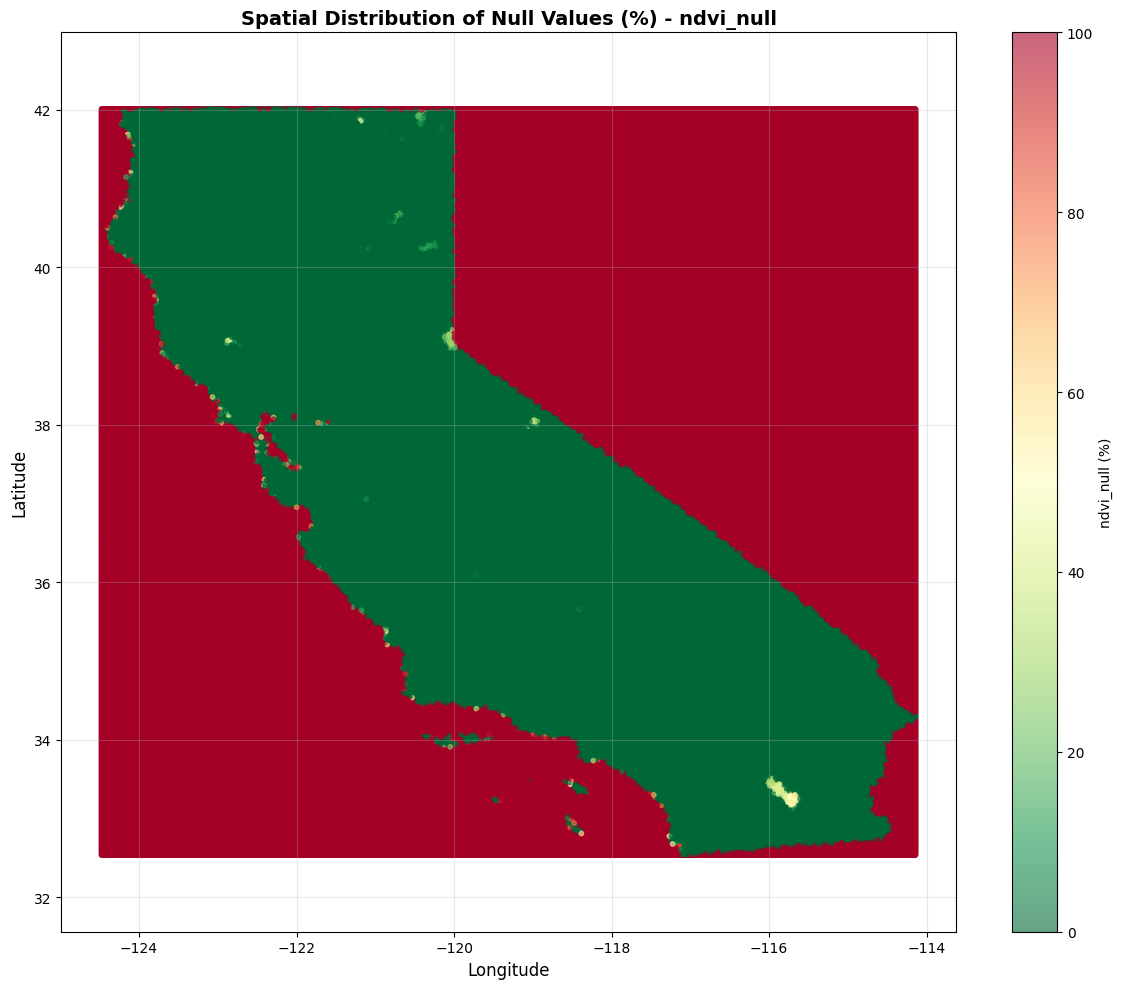

In [10]:
plot_null_map('ndvi_null')

Collected data
Plotting


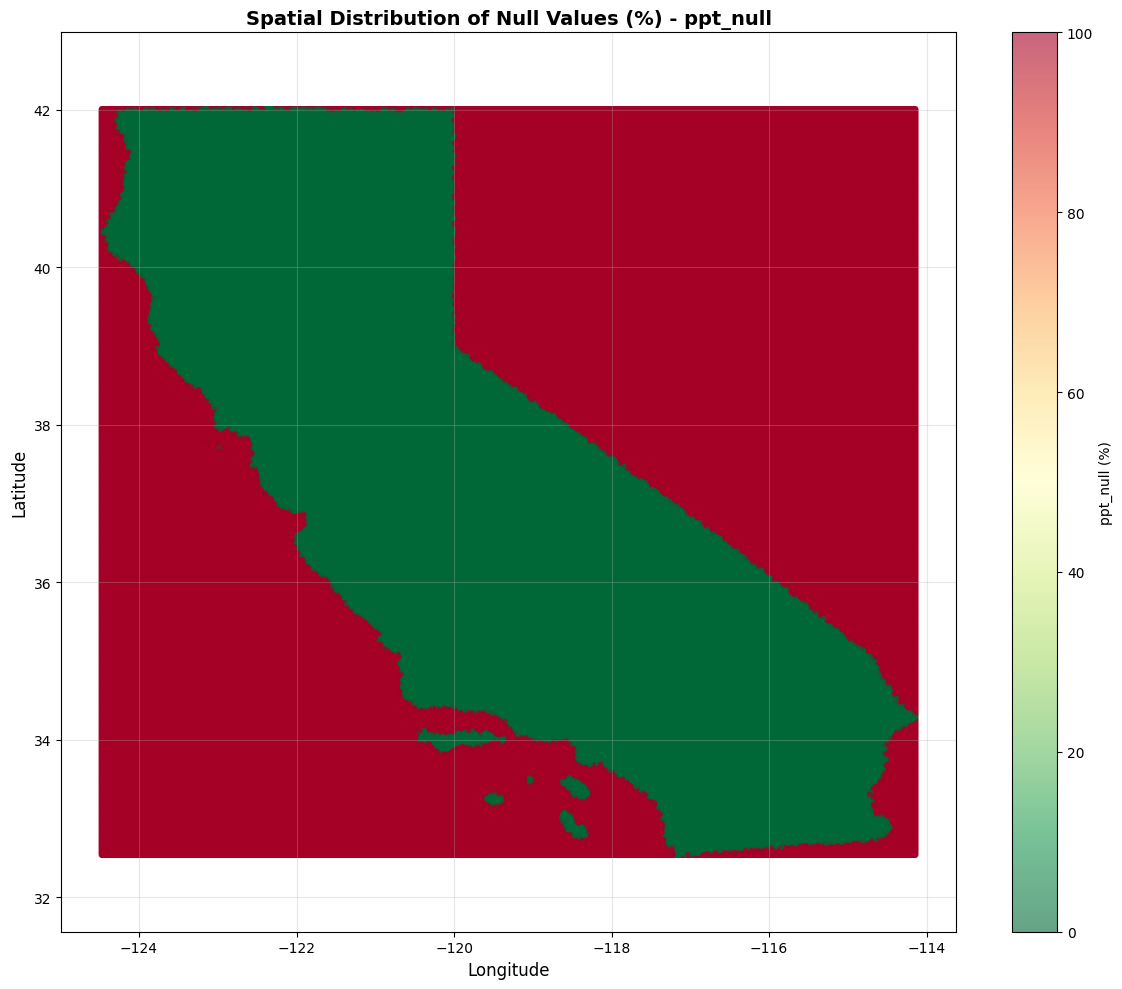

In [12]:
plot_null_map('ppt_null')

Collected data
Plotting


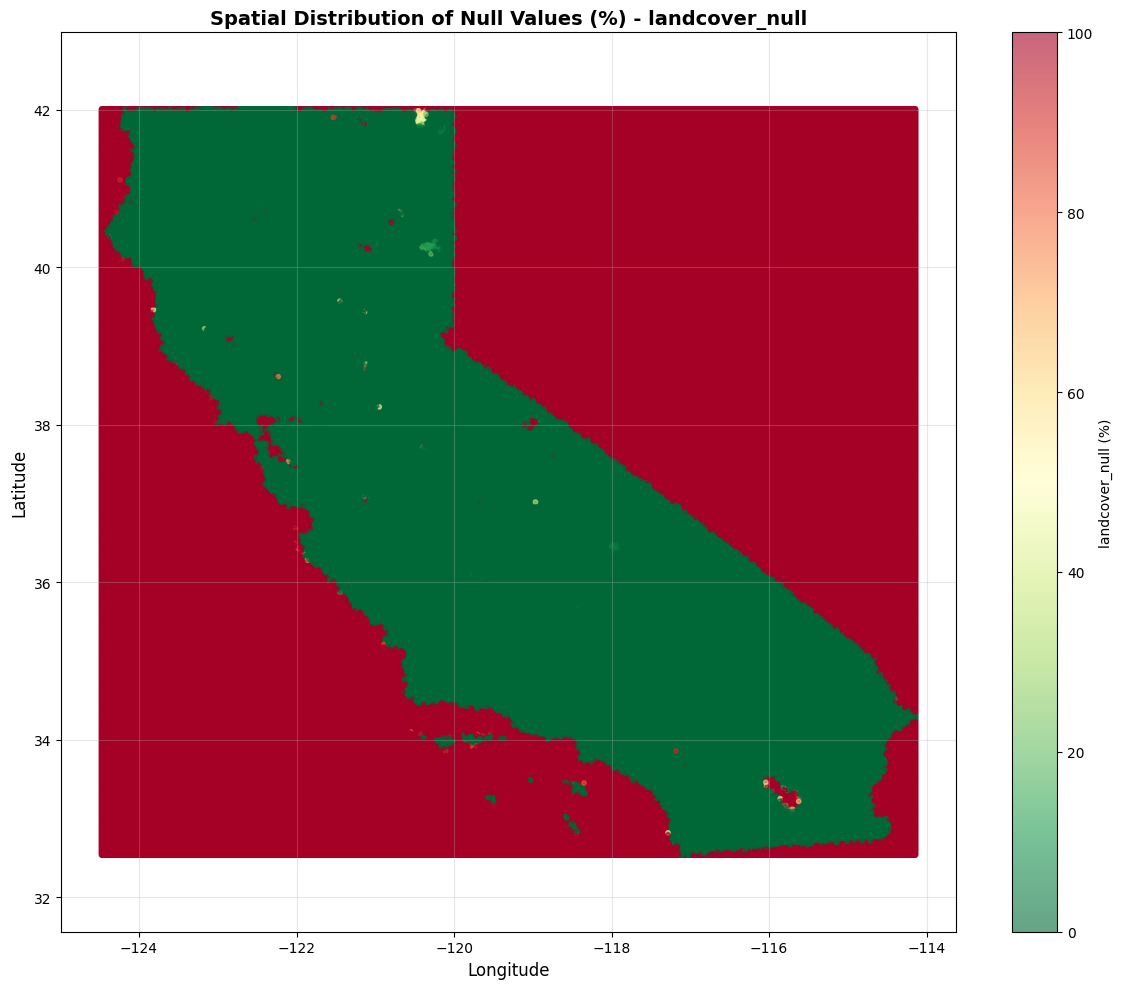

In [13]:
plot_null_map('landcover_null')

Collected data
Plotting


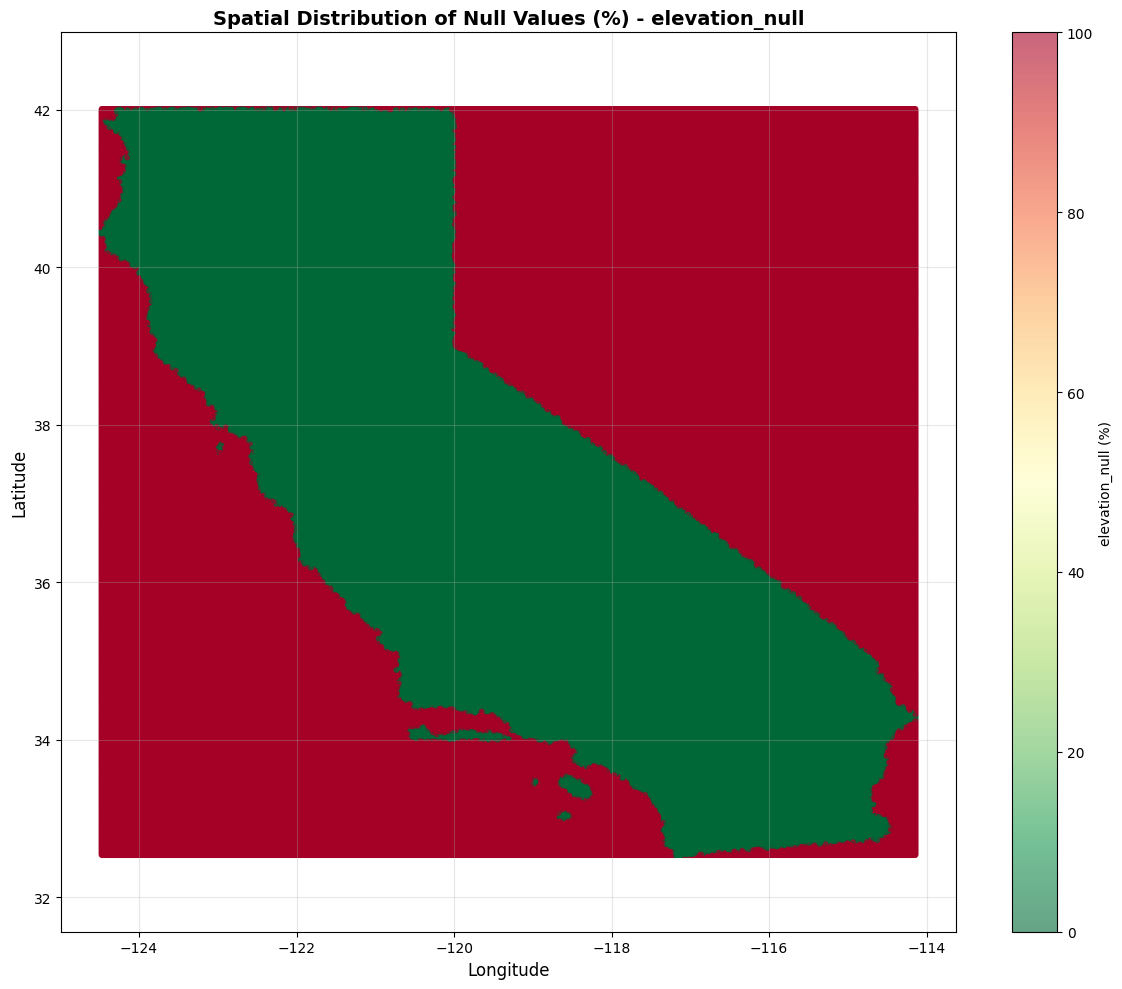

In [14]:
plot_null_map('elevation_null')

## Temporal Distribution Analysis

In [15]:
# Calculate basic stats using Polars
stats = df.select([
    pl.col('year').min().alias('min_year'),
    pl.col('year').max().alias('max_year'),
    pl.struct(['year', 'month']).n_unique().alias('unique_dates')
]).collect()

print(f"Years: {stats['min_year'][0]} to {stats['max_year'][0]}")
print(f"Unique year-month combinations: {stats['unique_dates'][0]}")

print(f"\nRecords per year:")
print(df.group_by('year').len().sort('year').collect())

print(f"\nRecords per month:")
print(df.group_by('month').len().sort('month').collect())

Years: 2000 to 2024
Unique year-month combinations: 299

Records per year:
shape: (25, 2)
┌──────┬──────────┐
│ year ┆ len      │
│ ---  ┆ ---      │
│ i32  ┆ u32      │
╞══════╪══════════╡
│ 2000 ┆ 15534838 │
│ 2001 ┆ 16947096 │
│ 2002 ┆ 16947096 │
│ 2003 ┆ 16947096 │
│ 2004 ┆ 16947096 │
│ …    ┆ …        │
│ 2020 ┆ 16947096 │
│ 2021 ┆ 16947096 │
│ 2022 ┆ 16947096 │
│ 2023 ┆ 16947096 │
│ 2024 ┆ 16947096 │
└──────┴──────────┘

Records per month:
shape: (12, 2)
┌───────┬──────────┐
│ month ┆ len      │
│ ---   ┆ ---      │
│ i32   ┆ u32      │
╞═══════╪══════════╡
│ 1     ┆ 33894192 │
│ 2     ┆ 35306450 │
│ 3     ┆ 35306450 │
│ 4     ┆ 35306450 │
│ 5     ┆ 35306450 │
│ …     ┆ …        │
│ 8     ┆ 35306450 │
│ 9     ┆ 35306450 │
│ 10    ┆ 35306450 │
│ 11    ┆ 35306450 │
│ 12    ┆ 35306450 │
└───────┴──────────┘


## Variable Distribution Analysis

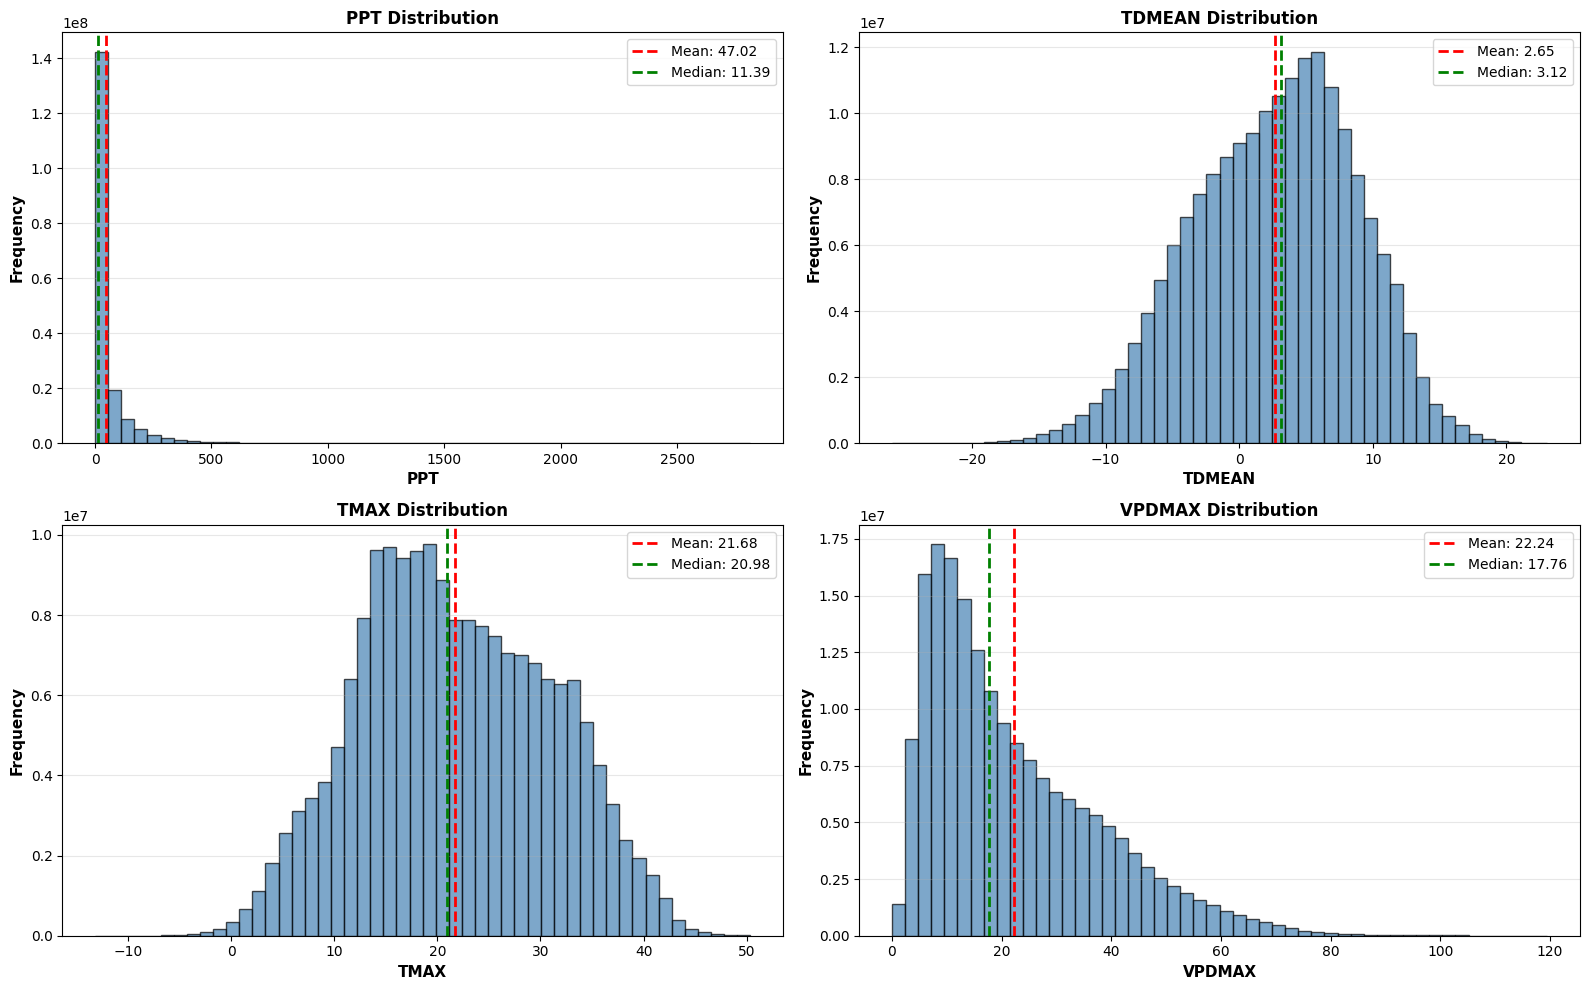

In [16]:
climate_vars = ['ppt', 'tdmean', 'tmax', 'vpdmax']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, var in enumerate(climate_vars):
    # Select specific column, drop nulls, and collect to Polars Series
    data = df.select(pl.col(var)).drop_nulls().collect().get_column(var)
    
    # Calculate stats using Polars Series methods
    mean_val = data.mean()
    median_val = data.median()
    
    # Plot histogram (Polars Series passes as array-like to matplotlib)
    axes[idx].hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[idx].set_xlabel(var.upper(), fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{var.upper()} Distribution', fontweight='bold', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

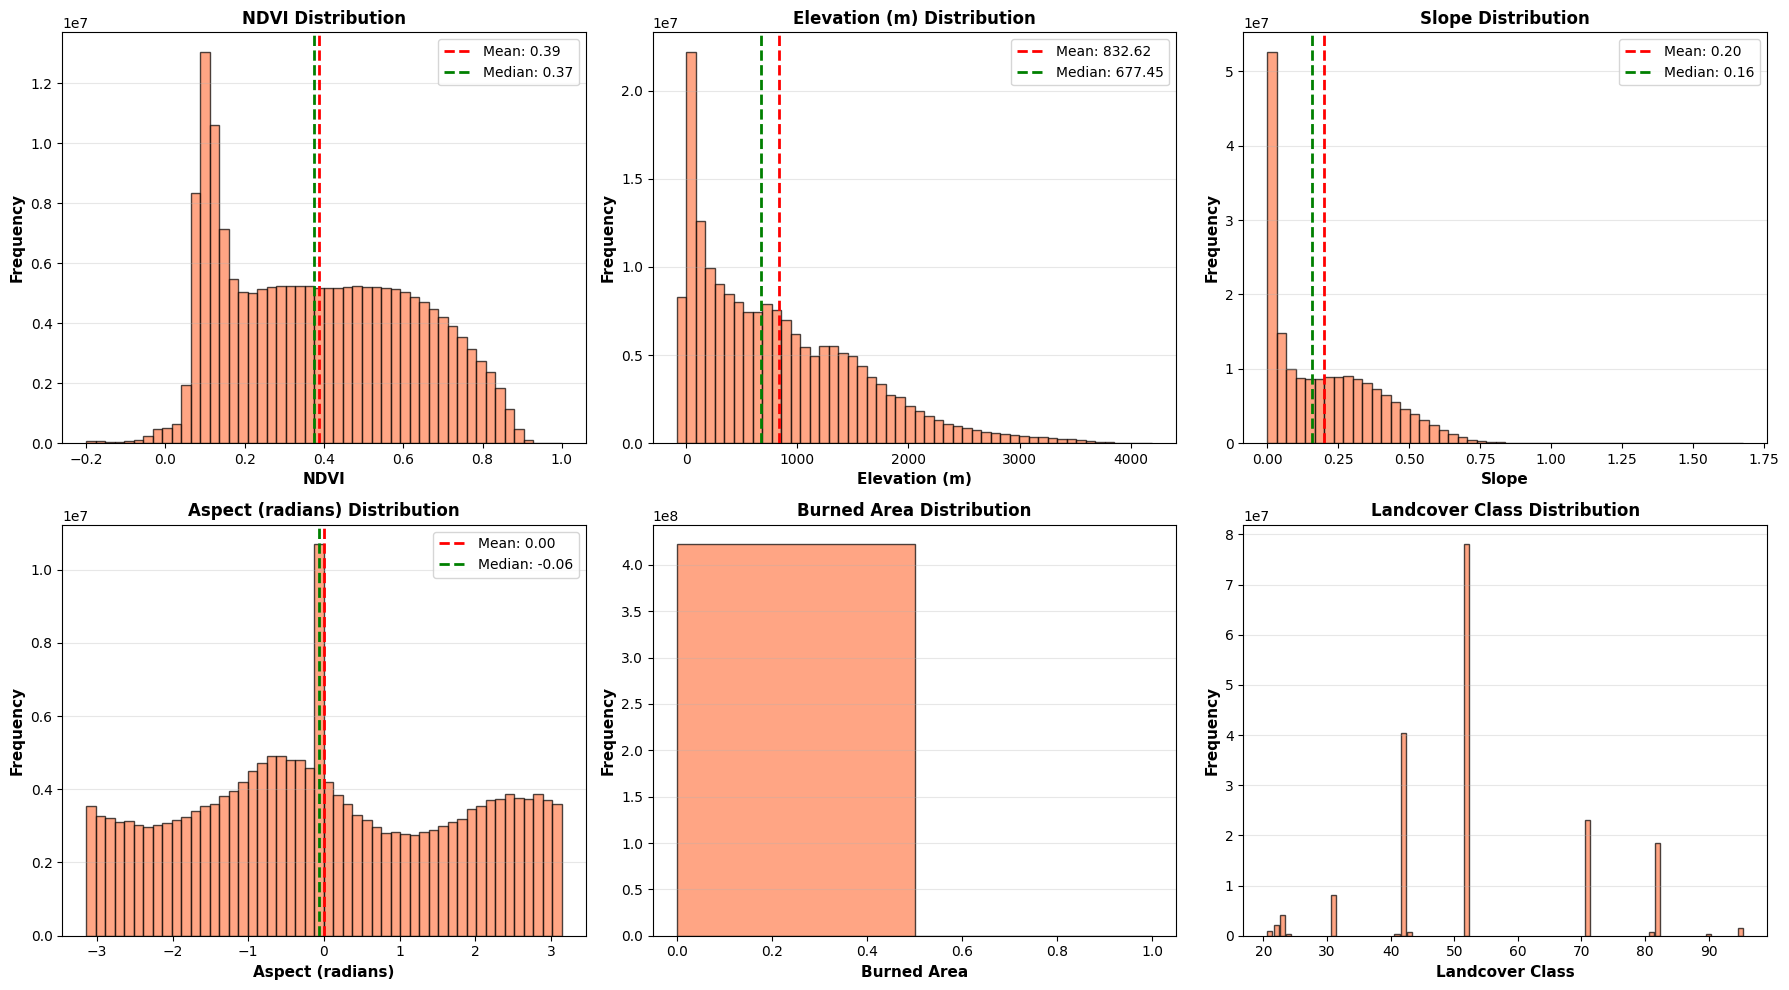

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

vars_to_plot = [
    ('ndvi', 'NDVI', 50),
    ('elevation', 'Elevation (m)', 50),
    ('slope', 'Slope', 50),
    ('aspect', 'Aspect (radians)', 50),
    ('burned_area', 'Burned Area', 2),
    ('landcover', 'Landcover Class', 20)
]

for idx, (var, label, bins) in enumerate(vars_to_plot):
    if var == 'landcover':
        # Polars: Calculate value counts directly
        vc = df.group_by(var).len().sort(var).collect()
        # Drop nulls if categorical (optional, usually safer for plotting)
        vc = vc.drop_nulls(var)
        
        axes[idx].bar(vc[var].to_list(), vc['len'].to_list(), alpha=0.7, color='coral', edgecolor='black')
        
    else:
        data = df.select(pl.col(var)).drop_nulls().collect().get_column(var)
        
        # Plot histogram
        axes[idx].hist(data, bins=bins, alpha=0.7, color='coral', edgecolor='black')
        
        if var != 'burned_area':
            mean_val = data.mean()
            median_val = data.median()
            axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
            axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[idx].set_xlabel(label, fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{label} Distribution', fontweight='bold', fontsize=12)
    
    if var != 'landcover' and var != 'burned_area':
        axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Correlation Analysis

In [7]:
numeric_cols = ['ppt', 'tdmean', 'tmax', 'vpdmax', 'burned_area', 'ndvi', 
                'landcover', 'elevation', 'slope', 'aspect']

# Calculate correlation matrix using Polars
corr_matrix_pl = df.select(numeric_cols).collect().corr()

# Plot using Seaborn (Seaborn can accept a Polars DataFrame directly)
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix_pl, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax,
            xticklabels=corr_matrix_pl.columns,
            yticklabels=corr_matrix_pl.columns,
            cbar_kws={'label': 'Correlation Coefficient'})

ax.set_title('Variable Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find strong correlations directly from Polars DataFrame
print("Strong Correlations (|r| > 0.5)")
columns = corr_matrix_pl.columns
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        # Access value by row index and column name
        val = corr_matrix_pl[i, columns[j]]
        if abs(val) > 0.5:
            print(f"{columns[i]:15s} <-> {columns[j]:15s}: {val:6.3f}")

: 

## Data Quality Summary

In [ ]:
numeric_cols = ['ppt', 'tdmean', 'tmax', 'vpdmax', 'burned_area', 'ndvi', 
                'landcover', 'elevation', 'slope', 'aspect']

# 1. Completeness
print("\n1. Completeness:")
total_records = df.select(pl.len()).collect().item()
unique_locs = df.select(pl.struct(['lat', 'lon']).n_unique()).collect().item()
time_stats = df.select([
    pl.col('year').min().alias('min_year'),
    pl.col('year').max().alias('max_year'),
    pl.col('year').n_unique().alias('n_years'),
    pl.col('month').n_unique().alias('n_months')
]).collect()

print(f"   - Total records: {total_records:,}")
print(f"   - Unique spatial locations: {unique_locs:,}")
print(f"   - Time range: {time_stats['min_year'][0]}-{time_stats['max_year'][0]} ({time_stats['n_years'][0]} years)")
print(f"   - Months covered: {time_stats['n_months'][0]} months")

# 2. Null Values
print("\n2. Null Values:")
null_counts = df.select(pl.all().null_count()).collect()
for col in null_counts.columns:
    count = null_counts[col][0]
    pct = count / total_records * 100
    if count > 0:
        print(f"   - {col:15s}: {count:8,} ({pct:5.2f}%)")
    else:
        print(f"   - {col:15s}: Complete")

# 3. Data Ranges
print("\n3. Data Ranges:")
valid_numeric = [c for c in numeric_cols if c in df..collect_schema().names()]
ranges = df.select([
    pl.col(c).min().alias(f"{c}_min") for c in valid_numeric
] + [
    pl.col(c).max().alias(f"{c}_max") for c in valid_numeric
]).collect()

for col in valid_numeric:
    min_val = ranges[f"{col}_min"][0]
    max_val = ranges[f"{col}_max"][0]
    print(f"   - {col:15s}: [{min_val:10.2f}, {max_val:10.2f}]")

# 4. Unique Values
print("\n4. Unique Values:")
unique_cols = ['landcover', 'burned_area', 'year', 'month']
unique_counts = df.select([
    pl.col(c).n_unique().alias(c) for c in unique_cols if c in df.collect_schema().names()
]).collect()

for col in unique_counts.columns:
    print(f"   - {col:15s}: {unique_counts[col][0]} unique values")


1. Completeness:
   - Total records: 422,265,142
   - Unique spatial locations: 1,412,258
   - Time range: 2000-2024 (25 years)
   - Months covered: 12 months

2. Null Values:
   - lat            : Complete
   - lon            : Complete
   - ppt            : 237,708,887 (56.29%)
   - year           : Complete
   - month          : Complete
   - tdmean         : 237,708,887 (56.29%)
   - tmax           : 237,708,887 (56.29%)
   - vpdmax         : 237,708,887 (56.29%)
   - burned_area    : Complete
   - ndvi           : 242,885,600 (57.52%)
   - landcover      : 242,782,499 (57.50%)
   - elevation      : 236,905,175 (56.10%)
   - slope          : 236,905,175 (56.10%)
   - aspect         : 236,905,175 (56.10%)

3. Data Ranges:


/tmp/ipykernel_18412/72704337.py:33: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  valid_numeric = [c for c in numeric_cols if c in df.columns]


   - ppt            : [      0.00,    2814.30]
   - tdmean         : [    -25.98,      23.05]
   - tmax           : [    -13.19,      50.35]
   - vpdmax         : [      0.00,     119.48]
   - burned_area    : [      0.00,       1.00]
   - ndvi           : [     -0.20,       1.00]
   - landcover      : [     21.00,      95.00]
   - elevation      : [    -84.88,    4193.28]
   - slope          : [      0.00,       1.68]
   - aspect         : [     -3.14,       3.14]

4. Unique Values:


/tmp/ipykernel_18412/72704337.py:49: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.col(c).n_unique().alias(c) for c in unique_cols if c in df.columns


   - landcover      : 15 unique values
   - burned_area    : 2 unique values
   - year           : 25 unique values
   - month          : 12 unique values
